# HLCV Assignment 2

### Prequel
This notebook contains skeletons that you are supposed to fill in (watch out for <font color='red'>**TODO**</font> tags). In general, you are expected to implement methods yourself. For example, when asked to implement a method computing histograms you can use numpy array functions that help you implement this task, but not use the numpy implementation `np.histogram` for your solution. To submit your assignment, upload your completed notebook and a PDF report (use the provided Latex template with, for example, [Overleaf](http://overleaf.com)) that contains your observations.

### Setting
In this exercise you will train (i) shallow classifiers and (ii) deep learning-based classifiers on a dataset containing 10 different types of clothing articles and compare their performance with each other.

In [92]:
import torch, torchvision, matplotlib.pyplot as plt, sklearn, numpy as np, tqdm.notebook as tqdm, time, copy
from IPython. display import clear_output

# Part I: SVM and Decision Boundaries

In this part of the exercise you will get better acquainted with the SVM algorithm using an artificially generated 2D classification problem. As you might recall from the lecture the problem setting is the following. We are given a training dataset $\{(X_i, y_i), i = 1, . . . ,N\}$, where $X_i$ is an *M*-dimensional feature vector and $y_i \in \{−1, 1\}$ is a label which denotes whether the corresponding point should be classified as negative or as positive. Further, we assume that the classification boundary has the form $y(X) = W^TX + w_0$.

The new point is classified as positive if $y(X) > 0$ and negative otherwise.

You can use the provided function to generate a simple 2D dataset in which positive and negative training points are sampled from 2 distinct Gaussian distributions. The last two parameters of this function allow to control the variance of the points, so that both linearly separable and linearly non-separable datasets can be generated.

### a) SVM Training

Use the following function to generate 2D Gaussian data and plot it.

In [108]:
def generate_gauss_data(N, mean_pos, mean_neg, std_pos, std_neg):
    state = np.random.RandomState(seed=42)
    pos = np.stack((
        state.normal(size=N, loc=mean_pos, scale=std_pos),
        state.normal(size=N, loc=0, scale=1)
    )).T
    neg = np.stack((
        state.normal(size=N, loc=mean_neg, scale=std_neg),
        state.normal(size=N, loc=0, scale=1)
    )).T
    return pos, neg

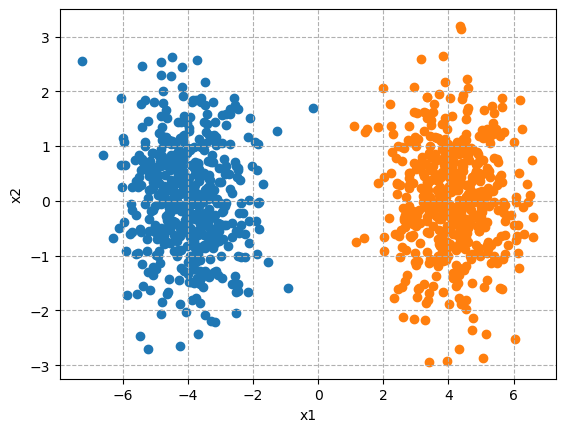

In [109]:
data_pos, data_neg = generate_gauss_data(
    N = 500,
    mean_pos = -4,
    mean_neg =  4,
    std_pos = 1,
    std_neg = 1
)
plt.scatter(data_pos[:,0], data_pos[:,1])
plt.scatter(data_neg[:,0], data_neg[:,1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(linestyle="--")
plt.show()

<font color='red'>**TODO:**</font> The following function trains an SVM on your generated Gaussian data. Make yourself familiar with the parameters of sklearn's SVM implementation (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). Then, run the code.

In [110]:
def train_svm(data_pos, data_neg, svm_pars):
    data = np.concatenate((data_pos, data_neg))
    labels = np.concatenate((
        np.ones(len(data_pos)),
        -np.ones(len(data_neg))
    ))

    clf = sklearn.svm.SVC(**svm_pars)
    return clf.fit(X=data, y=labels)

In [127]:
clf = train_svm(
    data_pos = data_pos,
    data_neg = data_neg,
    svm_pars  = {
        "kernel": "linear",
        "probability": True,
        "random_state": 3,
        "C": 1
    }
)

### b) SVM Visualization

<font color='red'>**TODO:**</font> Adjust the next cell to not only plot the training dataset, but also the support vectors and decision boundary of the trained SVM. The attribute section of the SVM documentary might help you with this.

In [145]:
def plot_svm(data_pos, data_neg, clf, title=None):
    # plot the training data
    
    plt.scatter(data_pos[:,0], data_pos[:,1])
    plt.scatter(data_neg[:,0], data_neg[:,1])

    # plot the decision boundary
    
    # mesh over data range 10 should be enough
    X_all = np.vstack([data_pos, data_neg])
    x_min, x_max = X_all[:,0].min() - 0.5, X_all[:,0].max() + 0.5
    y_min, y_max = X_all[:,1].min() - 0.5, X_all[:,1].max() + 0.5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 10),
        np.linspace(y_min, y_max, 10)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # decision function values
    functions = clf.decision_function(grid).reshape(xx.shape)

    # plot the decision boundary and the two margins = -1 and +1
    plt.contour(xx, yy, functions, levels=[0], colors='k', linewidths=2)
    
    # plot the support vectors
    
    plt.contour(xx, yy, functions, levels=[-1, 1], colors='g', linestyles='--')   
    
    plt.legend()
    plt.grid(linestyle="--")
    if title: plt.title(title)
    plt.show()


C:\Users\petar\AppData\Local\Temp\ipykernel_7232\4124426348.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


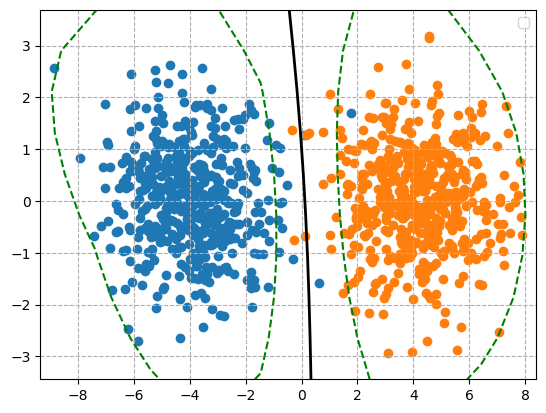

In [146]:
plot_svm(data_pos=data_pos, data_neg=data_neg, clf=clf)

### c) Linearly non-separable data
<font color='red'>**TODO:**</font> Find a setting where the data is not linearly separable anymore by changing the standard deviations.

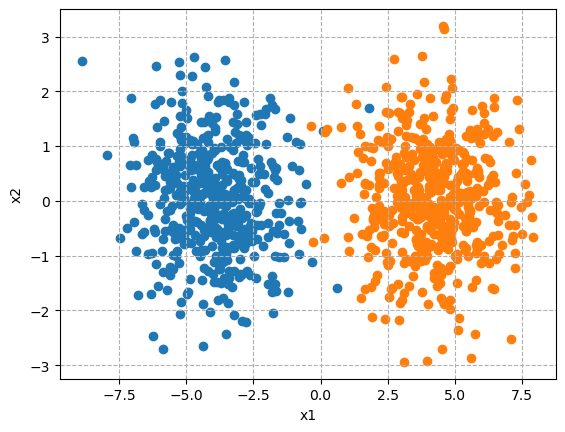

In [131]:
data_pos, data_neg = generate_gauss_data(
    N = 500,
    mean_pos = -4,
    mean_neg =  4,
    std_pos = 1.5,
    std_neg = 1.5
)
plt.scatter(data_pos[:,0], data_pos[:,1])
plt.scatter(data_neg[:,0], data_neg[:,1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(linestyle="--")
plt.show()

<font color='red'>**TODO:**</font> Train different SVM on the linearly non-separable data by varying their *C* parameter. Visualize their resulting decision boundaries and support vectors. What do you observe? What is the role of *C* in the SVM classification algorithm?

C:\Users\petar\AppData\Local\Temp\ipykernel_7232\4124426348.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


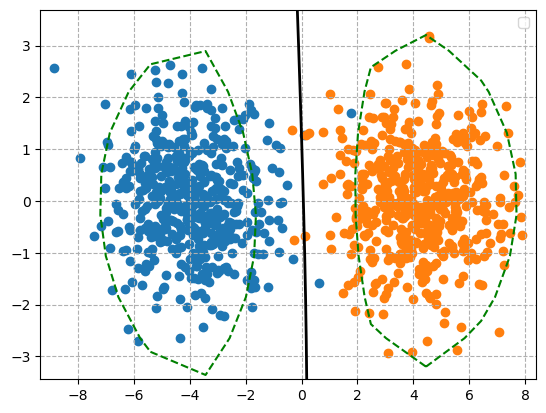

In [154]:
# add your code here
clf = train_svm(
    data_pos = data_pos,
    data_neg = data_neg,
    svm_pars  = {
        "kernel": "rbf",
        "probability": True,
        "random_state": 3,
        "C": 0.1
    }
)
plot_svm(data_pos=data_pos, data_neg=data_neg, clf=clf)

# Part II: Image Classification with Fashion-MNIST

### Download Fashion-MNIST and show samples.
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a (more challenging MNIST-like) dataset that contains 28x28 grayscale images of 10 different types of clothing articles, hence **10** classes. There is a training dataset containing 60k images and a test dataset containing 10k images. Torchvision provides functionality to download both datasets (see next cell), so it is sufficient to run the code.

In [67]:
dataset_train = torchvision.datasets.FashionMNIST("data", train=True,  download=True)
dataset_test  = torchvision.datasets.FashionMNIST("data", train=False, download=True)

Lets extract the images into numpy arrays. Also, show some sample images.

(60000, 28, 28) (10000, 28, 28)


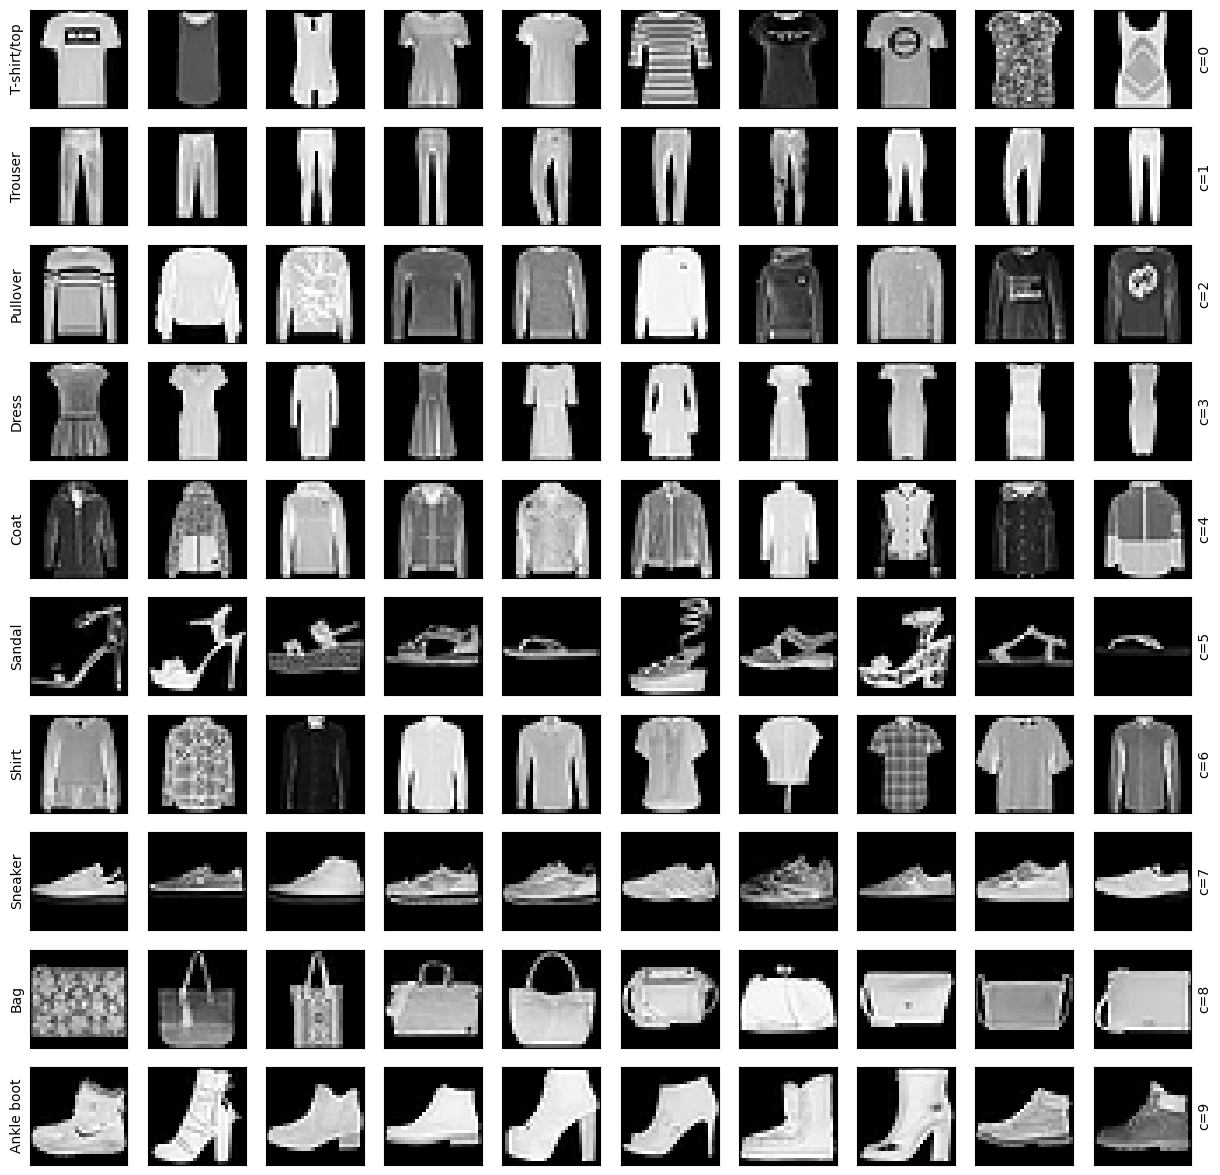

In [68]:
X_train = dataset_train.data.numpy()
y_train = dataset_train.targets.numpy()
X_test  = dataset_test.data.numpy()
y_test  = dataset_test.targets.numpy()

print(X_train.shape, X_test.shape)

f, ax = plt.subplots(10,10, figsize=(15,15))
for c in range(10):
    for i in range(10):
        ax[c,i].imshow(X_train[y_train==c][i], interpolation="none", cmap="gray")
        if i==0:
            ax[c,i].set_ylabel(dataset_train.classes[c])
        if i==9:
            ax[c,i].yaxis.set_label_position("right")
            ax[c,i].set_ylabel(f"c={c}")
        ax[c,i].set_yticks([])
        ax[c,i].set_xticks([])
plt.show()

We split the training dataset into a split used for training (50k images) and another split used for validation (10k images).

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = 10_000,
    random_state = 42,
    stratify = y_train
)

np.unique(y_val, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

### a) Shallow Learning - Image as input features
<font color='red'>**TODO:**</font> Choose at least 3 classifiers (of which one is Logistic Regression) from sklearn and train these models on the **training split**. Tune possible hyperparameters on the **validation split**. Finally, report your best found model (according to validation) with their corresponding performance (i) on the **training split**, (ii) on the **validation split**, and (iii) on the **test data**. Use `random_state=42` when initializing non-deterministic classifiers to get reproducable results. Compose your results (and found hyperparameters) in a table in your report.

You can find possible classifiers here: https://scikit-learn.org/stable/supervised_learning.html

Train, tune, and test different classifiers below.

In [7]:
# Here is an example printing the number of correctly classified training samples of a Logistic Regression.

from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(random_state=42, max_iter=200)
clf_log.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)
pred_train_log = clf_log.predict(X=X_train.reshape(len(X_train), -1))
print(f"Correctly predicted by Logistic Regression:{(pred_train_log==y_train).sum()}")

Correctly predicted by Logistic Regression:43519


c:\Users\petar\miniconda3\envs\HLCV\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
# Train and tune classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# params
param_sets_log = [
    {"random_state": 42, "max_iter": 200, "penalty": "l2", "C": 0.1},
    {"random_state": 42, "max_iter": 200, "penalty": "l2", "C": 0.5},
    {"random_state": 42, "max_iter": 200, "penalty": "l2", "C": 1}
]
best_perf_log = 0
best_params_log = None

param_sets_tree = [
    {"random_state": 42, "max_depth": 10, "min_samples_leaf": 10, "ccp_alpha": 0.0},
    {"random_state": 42, "max_depth": 10, "min_samples_leaf": 10, "ccp_alpha": 1e-5},
    {"random_state": 42, "max_depth": 15, "min_samples_leaf": 10, "ccp_alpha": 0.0},
    {"random_state": 42, "max_depth": 15, "min_samples_leaf": 10, "ccp_alpha": 1e-4},
    {"random_state": 42, "max_depth": 20, "min_samples_leaf": 10, "ccp_alpha": 0.0},
    {"random_state": 42, "max_depth": 20, "min_samples_leaf": 10, "ccp_alpha": 1e-4},
]

best_perf_tree = 0
best_params_tree = None

param_sets_KNN = [
    {"n_neighbors": 3, "n_jobs": 5, "weights": "uniform"},
    {"n_neighbors": 5, "n_jobs": 5, "weights": "uniform"},
    {"n_neighbors": 7, "n_jobs": 5, "weights": "uniform"},
    {"n_neighbors": 3, "n_jobs": 5, "weights": "distance"},
    {"n_neighbors": 5, "n_jobs": 5, "weights": "distance"},
    {"n_neighbors": 7, "n_jobs": 5, "weights": "distance"}
]
best_perf_KNN = 0
best_params_KNN = None
print("logistic regression")
# train models on train, tune on val
for params in param_sets_log:
    clf_log = LogisticRegression(**params)
    clf_log.fit(
        X = X_train.reshape(len(X_train), -1),
        y = y_train
    )
    
    pred_train_log = clf_log.predict(X=X_val.reshape(len(X_val), -1))
    correct_pred = (pred_train_log==y_val).sum()
    
    if correct_pred > best_perf_log:
        best_perf_log = correct_pred
        best_params_log = params

print("tree")
for params in param_sets_tree:
    clf_tree = DecisionTreeClassifier(**params)
    clf_tree.fit(
        X = X_train.reshape(len(X_train), -1),
        y = y_train
    )
    
    pred_train_tree = clf_tree.predict(X=X_val.reshape(len(X_val), -1))
    correct_pred = (pred_train_tree==y_val).sum()
    print(f"depth:{clf_tree.get_depth()}")
    print(f"nodes:{clf_tree.tree_.node_count}")
    
    if correct_pred > best_perf_tree:
        best_perf_tree = correct_pred
        best_params_tree = params

print("knn")
for params in param_sets_KNN:
    clf_KNN = KNeighborsClassifier(**params)
    clf_KNN.fit(
        X = X_train.reshape(len(X_train), -1),
        y = y_train
    )
    
    pred_train_KNN = clf_KNN.predict(X=X_val.reshape(len(X_val), -1))
    correct_pred = (pred_train_KNN==y_val).sum()
    
    if correct_pred > best_perf_KNN:
        best_perf_KNN = correct_pred
        best_params_KNN = params
        
print(f"Best parameters for {best_params_log=}")
print(f"Best parameters for {best_params_tree=}")
print(f"Best parameters for {best_params_KNN=}")




logistic regression


c:\Users\petar\miniconda3\envs\HLCV\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\petar\miniconda3\envs\HLCV\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessi

tree
depth:10
nodes:779
depth:10
nodes:755
depth:15
nodes:2291
depth:15
nodes:1229
depth:20
nodes:2987
depth:20
nodes:1355
knn
Best parameters for best_params_log={'random_state': 42, 'max_iter': 200, 'penalty': 'l2', 'C': 1}
Best parameters for best_params_tree={'random_state': 42, 'max_depth': 15, 'min_samples_leaf': 10, 'ccp_alpha': 0.0001}
Best parameters for best_params_KNN={'n_neighbors': 7, 'n_jobs': 5, 'weights': 'distance'}


In [9]:
# testing method
def test_performance(clf, X, y):
    pred = clf.predict(X=X.reshape(len(X), -1))
    correct_pred = (pred==y).sum()
    return correct_pred


In [10]:
# test performance for each dataset
# load models with best params
clf_log = LogisticRegression(**best_params_log)
clf_log.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)

clf_tree = DecisionTreeClassifier(**best_params_tree)
clf_tree.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)

clf_KNN = KNeighborsClassifier(**best_params_KNN)
clf_KNN.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)

# (i)
pred_train_log = test_performance(clf_log, X_train, y_train)
pred_train_tree = test_performance(clf_tree, X_train, y_train)
pred_train_KNN = test_performance(clf_KNN, X_train, y_train)

# (ii)
pred_val_log = test_performance(clf_log, X_val, y_val)
pred_val_tree = test_performance(clf_tree, X_val, y_val)
pred_val_KNN = test_performance(clf_KNN, X_val, y_val)

# (iii)
pred_test_log = test_performance(clf_log, X_test, y_test)
pred_test_tree = test_performance(clf_tree, X_test, y_test)
pred_test_KNN = test_performance(clf_KNN, X_test, y_test)

print(" -------- Correctly predicted by correct / total -------- ")

print(f"Correctly predicted by Logistic Regression on train set:{pred_train_log}/{len(X_train)}, accuracy: {pred_train_log/len(X_train)}")
print(f"Correctly predicted by Logistic Regression on val set:{pred_val_log}/{len(X_val)}, accuracy: {pred_val_log/len(X_val)}")
print(f"Correctly predicted by Logistic Regression on test set:{pred_test_log}/{len(X_test)}, accuracy: {pred_test_log/len(X_test)}")

print(f"Correctly predicted by Decision Tree on train set:{pred_train_tree}/{len(X_train)}, accuracy: {pred_train_tree/len(X_train)}")
print(f"Correctly predicted by Decision Tree on val set:{pred_val_tree}/{len(X_val)}, accuracy: {pred_val_tree/len(X_val)}")
print(f"Correctly predicted by Decision Tree on test set:{pred_test_tree}/{len(X_test)}, accuracy: {pred_test_tree/len(X_test)}")

print(f"Correctly predicted by KNN on train set:{pred_train_KNN}/{len(X_train)}, accuracy: {pred_train_KNN/len(X_train)}")
print(f"Correctly predicted by KNN on val set:{pred_val_KNN}/{len(X_val)}, accuracy: {pred_val_KNN/len(X_val)}")
print(f"Correctly predicted by KNN on test set:{pred_test_KNN}/{len(X_test)}, accuracy: {pred_test_KNN/len(X_test)}")

c:\Users\petar\miniconda3\envs\HLCV\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 -------- Correctly predicted by correct / total -------- 
Correctly predicted by Logistic Regression on train set:43519/50000, accuracy: 0.87038
Correctly predicted by Logistic Regression on val set:8559/10000, accuracy: 0.8559
Correctly predicted by Logistic Regression on test set:8404/10000, accuracy: 0.8404
Correctly predicted by Decision Tree on train set:44126/50000, accuracy: 0.88252
Correctly predicted by Decision Tree on val set:8219/10000, accuracy: 0.8219
Correctly predicted by Decision Tree on test set:8049/10000, accuracy: 0.8049
Correctly predicted by KNN on train set:50000/50000, accuracy: 1.0
Correctly predicted by KNN on val set:8635/10000, accuracy: 0.8635
Correctly predicted by KNN on test set:8504/10000, accuracy: 0.8504


In [11]:
# Approximate the generalization error of your best found hyperparameter combinations for each classifier

acc_log = pred_test_log/len(X_test)
acc_tree = pred_test_tree/len(X_test)
acc_KNN = pred_test_KNN/len(X_test)

gene_err_log = 1 - acc_log
gene_err_tree = 1 - acc_tree
gene_err_KNN = 1 - acc_KNN

print(" ------- Generalization error for the best models ------- ")
print(f"Generalization error for Logistic Regression: {gene_err_log}")
print(f"Generalization error for Decision Tree: {gene_err_tree}")
print(f"Generalization error for KNN: {gene_err_KNN}")

 ------- Generalization error for the best models ------- 
Generalization error for Logistic Regression: 0.15959999999999996
Generalization error for Decision Tree: 0.19510000000000005
Generalization error for KNN: 0.14959999999999996


### b) Deep Learning - Learn to Extract Features from Images
### Defining our classification network.

In [12]:
class CNNClassifier(torch.nn.Module):
    def __init__(self, kernel_size=3, out_channels=16, pool_size=7):
        # inherit from torch.nn.Module
        super(type(self), self).__init__()
        assert (28%pool_size) == 0, "pool_size must be a divisible of image dimensions (28)"
        self.conv = torch.nn.Conv2d(
            kernel_size = kernel_size,
            in_channels = 1,
            out_channels = out_channels,
            padding = "same"
        )
        self.linear = torch.nn.Linear(out_channels*((28//pool_size)**2), 10)
        self.pool_size = pool_size
        
    def forward(self, x):
        # input image size: x.shape = Bx1x28x28 (Batchsize x Channels x Height x Width)
        x = self.conv(x)
        x = torch.nn.functional.relu(x)
        # feature maps size: x.shape = Bx16x28x28
        # reduce spatial dimensionality of feature maps
        x = torch.nn.functional.avg_pool2d(x, kernel_size=self.pool_size)
        # feature maps size: x.shape = Bx16x4x4
        # flatten features for input to linear layer
        x_feat = x.reshape(len(x), -1)
        # dimensionality of features is now 16*4*4 = Bx256
        # previously, the dimensionality of inputting the plain images was: 28*28=784
        y_logits = self.linear(x_feat)
        # now we have prediction scores for each class: x.shape == Bx10
        return y_logits, x_feat

    def reset_parameters(self):
        self.conv.reset_parameters()
        self.linear.reset_parameters()

### Training our classification network.

The following cells contain utility functions.
- `plot_perf`: You can collect your measures into lists and use the following function to plot your results.
- `save_state`: Use this function to save the state of a network.
- `load_state`: Use this function to create a CNNClassifier from a saved state.

In [13]:
def plot_perf(train:list, val:list , name:list, share_axis=False, hyperparams=None, epoch=None, all_epochs=None):
    assert len(train) == len(val) == len(name)
    
    f, host = plt.subplots(figsize=(8,5))
    handles = []
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    plt.xlabel("Epoch")
    plt.grid(linestyle="--")
    
    for i in range(len(train)):
        ax = plt.gca()
        if not share_axis:
            if i == 0:
                ax = host
            else:
                ax = host.twinx()
            ax.set_ylabel(name[i], c=colors[i])
            ax.tick_params(axis="y", colors=colors[i])
        
        handles += ax.plot(train[i], label=f"{name[i]}, train", c=colors[i])
        handles += ax.plot(val[i], label=f"{name[i]}, val", c=colors[i], linestyle="--")
    
    f.suptitle("Training and Validation Performance for Hyperparameters\n" + str(hyperparams))
    plt.legend(handles=handles, bbox_to_anchor=(1.04, 1), loc="upper left")
    if epoch == (all_epochs-1):
        pic_name = f"performance_ks{hyperparams['kernel_size']}_oc{hyperparams['out_channels']}_ps{hyperparams['pool_size']}.png"
        plt.savefig(pic_name)
    plt.show()

In [14]:
def save_state(network, optimizer, name, measures):
    torch.save({
        "net": network.state_dict(),
        "optimizer": optimizer.state_dict(),
        "params": {
            "kernel_size": network.conv.kernel_size,
            "out_channels": network.conv.out_channels,
            "pool_size": network.pool_size
        },
        "measures": measures
    }, f"savestate_{name}.torch")

In [15]:
def load_state(name, map_location):
    load = torch.load(f"savestate_{name}.torch", map_location=map_location)
    network = CNNClassifier(**load["params"])
    network.load_state_dict(load["net"])
    return network, load["optimizer"], load["measures"]

Preparing data for Pytorch.

In [16]:
use_gpu = True

In [17]:
data_train, data_val = torch.from_numpy(X_train).float()/255, torch.from_numpy(X_val).float()/255
# Pytorch models expect input in the shape of BxCxHxW, therefore we add a channel dimension
data_train, data_val = data_train.unsqueeze(dim=1), data_val.unsqueeze(dim=1)
data_test, target_test = (torch.from_numpy(X_test).float()/255).unsqueeze(1), torch.from_numpy(y_test)
target_train, target_val = torch.from_numpy(y_train), torch.from_numpy(y_val)

dataset_train = torch.utils.data.TensorDataset(data_train, target_train)
dataset_val   = torch.utils.data.TensorDataset(data_val,   target_val)
dataset_test  = torch.utils.data.TensorDataset(data_test,  target_test)

dataloader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = 64,
    shuffle = True,
)

dataloader_val = torch.utils.data.DataLoader(
    dataset = dataset_val,
    batch_size = 64,
    shuffle = False,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset = dataset_test,
    batch_size = 64,
    shuffle = False,
)

In [18]:
models = {}

Create the network.

In [20]:
network = CNNClassifier(
    kernel_size = 3,
    out_channels = 100,
    pool_size = 7
)
# move to GPU if GPU is available
if use_gpu and torch.cuda.is_available():
    network = network.cuda()

print(network)
print()
print("\n".join([f"{name}: {p.shape} -> {p.numel()} parameters" for name, p in network.named_parameters()]))
print()
print(f"Total number of parameters: {sum([p.shape.numel() for p in network.parameters()])}")

CNNClassifier(
  (conv): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (linear): Linear(in_features=1600, out_features=10, bias=True)
)

conv.weight: torch.Size([100, 1, 3, 3]) -> 900 parameters
conv.bias: torch.Size([100]) -> 100 parameters
linear.weight: torch.Size([10, 1600]) -> 16000 parameters
linear.bias: torch.Size([10]) -> 10 parameters

Total number of parameters: 17010


Create optimizer and loss function.

In [21]:
optimizer = torch.optim.Adam(network.parameters())
loss = torch.nn.CrossEntropyLoss()

### Training loop

<font color='red'>**TODO:**</font> Adjust the training loop by implementing the following functionalities:
- Currently, the only measurements collected is the training loss. Add other performance measures.
- Currently, the validation data is not evaluated. Add performance measures for the validation data.

You can use function `plot_perf` to plot your measurements and `save_state` to save your network at any time (e.g. when the validation measures are good).

<font color='red'>**TODO:**</font> Find a combination of hyperparameters that works well for your network. Report the hyperparameters you tried with their corresponding training and validation measures in a table in your report.

In [ ]:
def train(network_train, hyperparams=None, epochs=100):    
    network_train.reset_parameters()

    train_losses = []
    val_losses = []
    # example to show how plot_perf works, delete the following two lines after you understand the function
    train_accuracies = []
    val_accuracies = []
    time_start = time.time()
    epochs = epochs
    best_loss_train = float("inf")

    for epoch in tqdm.trange(epochs):
        # train variables
        train_loss = 0
        train_correct = 0
        train_accuracy = 0
        
        # 1. Train the network
        for x, y in dataloader_train:
            # delete previous gradient calculations
            optimizer.zero_grad()
            # move to GPU if GPU is available
            if use_gpu and torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
            
            # predict class logits for each image in the batch
            y_pred, _ = network_train(x)
            # compute the loss
            L = loss(y_pred, y)
            # compute gradients
            L.backward()
            # change parameters of the network
            optimizer.step()
            
            train_loss += L.item()
            # accuracy
            preds = y_pred.argmax(dim=1)
            train_correct += (preds == y).sum().item()
            
        train_loss /= len(dataloader_train.dataset)
        train_accuracy = train_correct / len(dataloader_train.dataset)
        
        # 2. Validate the network
        # validation variables
        val_loss = 0
        val_correct = 0
        val_accuracy = 0
        
        with torch.no_grad(): # we don't need gradients: speeds up computations
            for x, y in dataloader_val:
                
                if use_gpu and torch.cuda.is_available():
                    x = x.cuda()
                    y = y.cuda()
                    
                y_pred, _ = network_train(x)
                L = loss(y_pred, y)
                val_loss += L.item()
                
                # accuracy
                preds = y_pred.argmax(dim=1)
                val_correct += (preds == y).sum().item()
        
        val_loss /= len(dataloader_val.dataset)
        val_accuracy = val_correct / len(dataloader_val.dataset)
        
        # 3. collect all measures
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]
        
        # clear cell output to replot progress
        clear_output(wait=True)
        
        # some output
        print(f"[{epoch:>2}] Train loss: {train_loss:.5f}")
        time_past = time.time() - time_start
        time_per_epoch = time_past / (epoch+1)
        eta = (epochs-1-epoch) * time_per_epoch
        print(f"[{epoch:>2}] Time: {time_past:.1f}s, Time-per-Epoch: {time_per_epoch:.1f}s, eta: {eta:.1f}s")
        
        # takes lists of lists as input:
        # each item of argument ´train´ expects a corresponding item in ´val´.
        plot_perf(
            train = [train_losses, train_accuracies],
            val = [val_losses, val_accuracies],
            name = ["loss", "accuracy"],
            hyperparams = hyperparams,
            epoch=epoch,
            all_epochs=epochs
        )
        
        if best_loss_train > val_loss:
            best_loss_train = val_loss
            best_state = {
                "model": copy.deepcopy(network_train.state_dict()),
                "opt":   copy.deepcopy(optimizer.state_dict())
            }
            measures = {
                "loss": val_loss,
                "accuracy": val_accuracy
            }
    return best_loss_train, best_state, measures

[ 4] Train loss: 0.00490
[ 4] Time: 31.4s, Time-per-Epoch: 6.3s, eta: 595.8s


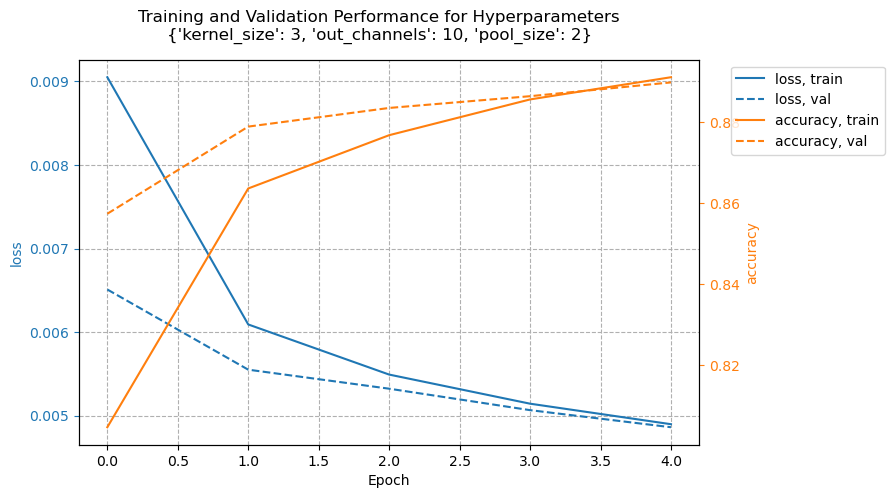

KeyboardInterrupt: 

In [ ]:
# creating a hyperparameter loop
best_loss = float("inf")

for kernel_size in [3, 5, 7]:
    for out_channels in [10, 50, 100]:
        for pool_size in [2, 4, 7]:
            hyperparams = {
                "kernel_size": kernel_size,
                "out_channels": out_channels,
                "pool_size": pool_size
            }
            
            network = CNNClassifier(
                kernel_size = kernel_size,
                out_channels = out_channels,
                pool_size = pool_size
            )
            # move to GPU if GPU is available
            if use_gpu and torch.cuda.is_available():
                network = network.cuda()

            print(network)
            print()
            print("\n".join([f"{name}: {p.shape} -> {p.numel()} parameters" for name, p in network.named_parameters()]))
            print()
            print(f"Total number of parameters: {sum([p.shape.numel() for p in network.parameters()])}")

            optimizer = torch.optim.Adam(network.parameters())
            loss = torch.nn.CrossEntropyLoss()
            
            val_loss, best_state, measures = train(network, hyperparams=hyperparams)
            
            network.load_state_dict(best_state["model"])
            optimizer.load_state_dict(best_state["opt"])
            
            if (val_loss < best_loss):
                best_loss = val_loss
                save_state(network=network, optimizer=optimizer, name="best", measures=measures)
            
            
        

<font color='red'>**TODO:**</font> Approximate the generalization performance of your best network. There is no code for this so far, you have to implement it.

In [ ]:
# Test your network's performance on the test data
network, optimizer, measures = load_state("best", map_location="cpu")
loss = torch.nn.CrossEntropyLoss()
test_loss = 0
test_correct = 0
print(network)

with torch.no_grad():
    for x, y in dataloader_test:
        if use_gpu and torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            network = network.cuda()
        
        y_pred, x_feat = network(x)
        L = loss(y_pred, y)
        test_loss += L.item()
        preds = y_pred.argmax(dim=1)
        test_correct += (preds == y).sum().item()

print(f"Loss: {(test_loss/len(dataloader_test.dataset)):.5f}, Accuracy: {test_correct / len(dataloader_test.dataset):.5f}")

CNNClassifier(
  (conv): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (linear): Linear(in_features=4900, out_features=10, bias=True)
)
Loss: 0.00387, Accuracy: 0.91870


### c) Visualizing kernels

<font color='red'>**TODO:**</font> Visualize the kernels of one of your models (do not use a model that has too many kernels, but at least 9). Write in your report what you observe looking at the kernels and try to speculate about the features they extract.

In [53]:
def plot_kernels(network):
    kernels, bias = list(network.conv.parameters())
    kernels = kernels.detach().cpu()
    # scale between [-1,1]
    kernels = kernels / kernels.abs().reshape(len(kernels), -1).max(dim=1)[0].unsqueeze(1).unsqueeze(1).unsqueeze(1)

    plt.figure(figsize=(15,15))
    # plot kernels
    plt.imshow(
        torchvision.utils.make_grid(
            kernels,
            nrow = int(np.ceil(np.sqrt(len(kernels)))),
            pad_value = .0
        ).permute(1,2,0).mean(dim=2),
        cmap = "bwr",
        vmin = -1,
        vmax = 1
    )
    plt.axis("off")
    plt.colorbar()

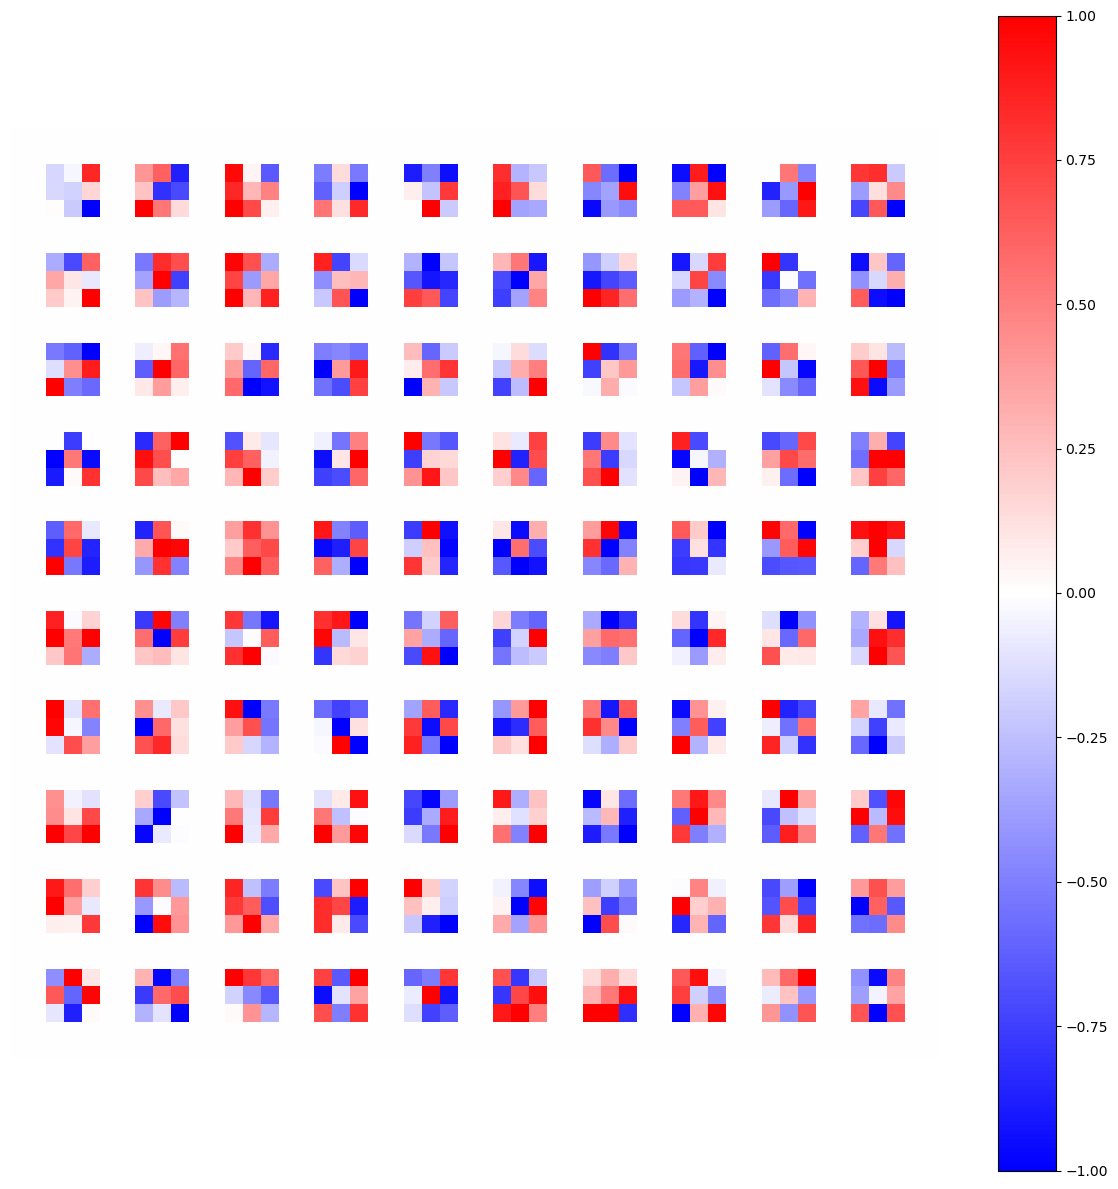

In [54]:
plot_kernels(network)

### d) Classify Learned Features with ML Models
<font color='red'>**TODO:**</font> Implement a function that - given a dataloader and network - extracts features (after the convolutional layer) for each image. Collect the features to generate training, validation, and test datasets. Use these datasets to train and evaluate your classifiers of Q1. Summarize your results in a table in your report and answer the following questions:
- How did the performance of each classifier evolve with the new set of features?
- Why do you think their performance improves / deteriorates (for each case)?

In [23]:
def extract_features(dataloader, network):
    features = []
    targets = []
    
    with torch.no_grad():
        for x, y in dataloader:
            targets += [y.detach().cpu().numpy()]
            
            if 'use_gpu' in globals() and torch.cuda.is_available():
                x = x.cuda()
                y = y.cuda()
                network = network.cuda()
                
            logits, x_feat = network(x)
            
            features += [x_feat.detach().cpu().numpy()]
        
    return np.concatenate(features), np.concatenate(targets)

In [24]:
# Generate datasets
network, optimizer, measures = load_state("best", map_location="cpu") # assign the best model to the network variable

X_train, y_train = extract_features(dataloader_train, network)
X_val, y_val = extract_features(dataloader_val, network)
X_test, y_test = extract_features(dataloader_test, network)


In [25]:
# Train models on generated datasets
# Train models
clf_log = LogisticRegression(**best_params_log)
clf_log.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)

clf_tree = DecisionTreeClassifier(**best_params_tree)
clf_tree.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)

clf_KNN = KNeighborsClassifier(**best_params_KNN)
clf_KNN.fit(
    X = X_train.reshape(len(X_train), -1),
    y = y_train
)

# Test models
pred_test_log = test_performance(clf_log, X_test, y_test)
pred_test_tree = test_performance(clf_tree, X_test, y_test)
pred_test_KNN = test_performance(clf_KNN, X_test, y_test)


c:\Users\petar\miniconda3\envs\HLCV\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [155]:
print(f"Correctly predicted by Logistic Regression on test set:{pred_test_log}/{len(X_test)}, accuracy: {pred_test_log/len(X_test)}")
print(f"Correctly predicted by Decision Tree on test set:{pred_test_tree}/{len(X_test)}, accuracy: {pred_test_tree/len(X_test)}")
print(f"Correctly predicted by KNN on test set:{pred_test_KNN}/{len(X_test)}, accuracy: {pred_test_KNN/len(X_test)}")

Correctly predicted by Logistic Regression on test set:9174/10000, accuracy: 0.9174
Correctly predicted by Decision Tree on test set:8271/10000, accuracy: 0.8271
Correctly predicted by KNN on test set:8800/10000, accuracy: 0.88


### e) Deeper Learning
<font color='red'>**TODO:**</font> The network in Q2 is still quite shallow. You can increase its depth by, for example, adding more convolutional layers. Extend the code (or create a new class) such that you are able to add more convolutional and more linear layers. Train a deeper network. How good can your network become?

In [69]:
dataset_train = torchvision.datasets.FashionMNIST("data", train=True,  download=True)
dataset_test  = torchvision.datasets.FashionMNIST("data", train=False, download=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = 10_000,
    random_state = 42,
    stratify = y_train
)

np.unique(y_val, return_counts=True)
data_train, data_val = torch.from_numpy(X_train).float()/255, torch.from_numpy(X_val).float()/255
# Pytorch models expect input in the shape of BxCxHxW, therefore we add a channel dimension
data_train, data_val = data_train.unsqueeze(dim=1), data_val.unsqueeze(dim=1)
data_test, target_test = (torch.from_numpy(X_test).float()/255).unsqueeze(1), torch.from_numpy(y_test)
target_train, target_val = torch.from_numpy(y_train), torch.from_numpy(y_val)

dataset_train = torch.utils.data.TensorDataset(data_train, target_train)
dataset_val   = torch.utils.data.TensorDataset(data_val,   target_val)
dataset_test  = torch.utils.data.TensorDataset(data_test,  target_test)

dataloader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = 64,
    shuffle = True,
)

dataloader_val = torch.utils.data.DataLoader(
    dataset = dataset_val,
    batch_size = 64,
    shuffle = False,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset = dataset_test,
    batch_size = 64,
    shuffle = False,
)

In [72]:
def save_state_deepCNN(network, optimizer, name, measures):
    torch.save({
        "net": network.state_dict(),
        "optimizer": optimizer.state_dict(),
        "params": {
            "channels": network.channels,
            "kernel_size": network.kernel_size,
            "pool_size": network.pool_size
        },
        "measures": measures
    }, f"savestate_{name}.torch")
    
def load_state_DeepCNN(name, map_location):
    load = torch.load(f"savestate_{name}.torch", map_location=map_location)
    network = DeepCNN(**load["params"])
    network.load_state_dict(load["net"])
    return network, load["optimizer"], load["measures"]

In [62]:
# Conduct your experiments here
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN(nn.Module):
    """
    A deeper version of your CNN:
      [Conv-BN-ReLU] x B -> (optional Dropout) -> AdaptiveAvgPool -> Flatten -> Linear
    Keeps forward signature: returns (logits, x_feat).
    """
    def __init__(
        self,
        in_channels=1,
        num_classes=10,
        channels=(16, 32, 64),      # number of channels per conv block
        kernel_size=3,
        pool_size=2,
        input_size=28
    ):
        # dimension (B, C, H, W)
        super().__init__()
        assert (28%pool_size) == 0, "pool_size must be a divisible of image dimensions (28)"
        self.num_classes = num_classes
        self.pool_size = pool_size
        self.num_pools = len(channels)
        self.out_channel = channels[-1]
        
        # for saving params
        self.channels = channels
        self.kernel_size = kernel_size
        

        # convolutional feature extractor 
        layers = []
        c_prev = in_channels
        pad = kernel_size // 2       # padding caclulation, so that the spatial size can remain the same after conv
        
        # adding each layer to the sequence
        for c in channels:
            layers += [
                nn.Conv2d(c_prev, c, kernel_size=kernel_size, padding=pad), # (in,out,kernelsize,padding)
                nn.BatchNorm2d(c),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=pool_size, stride=pool_size) # reducing spatial and obtaining more spatial information
            ]
            c_prev = c # last channels = out channel
            
        # the whole sequence is the feature extractor
        self.conv = nn.Sequential(*layers)

        h = input_size # h = w in this case since the picture has squared dimensions
        for _ in range(self.num_pools):
            h = h // pool_size
            
        # linear layer
        self.linear = nn.Linear(self.out_channel * h * h, 10)

    def forward(self, x):
        x = self.conv(x)                 
        x_feat = x.view(x.size(0), -1)   
        y_logits = self.linear(x_feat)   # (B, num_classes)
        return y_logits, x_feat
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
                m.reset_parameters()


[24] Train loss: 0.00035
[24] Time: 568.7s, Time-per-Epoch: 22.7s, eta: 0.0s


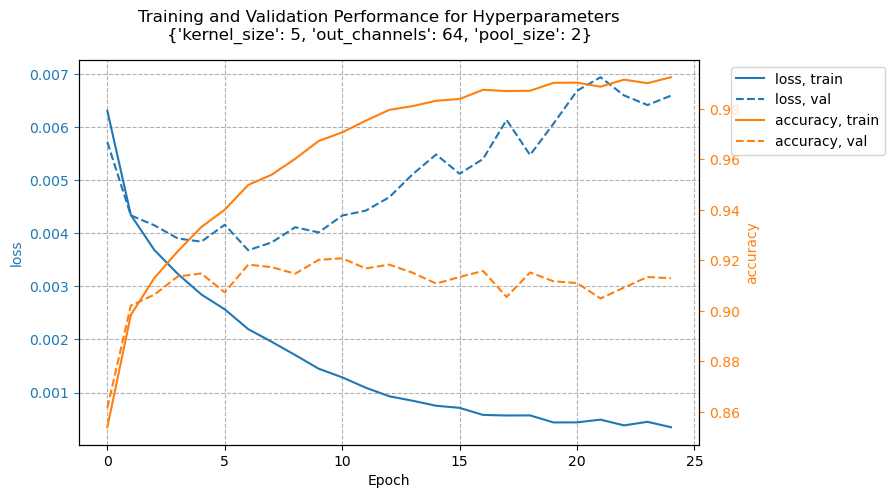

In [85]:
networkDeep = DeepCNN(kernel_size=5,channels=(16, 32, 64)) # first try 3 layers 16, 32, 64 overfit to training

DeepCNN_loss = float("inf") # saved it in case i use it later for the hyperparameter loop but i decided to try out different hyperparameters

hyperparams = {
    "kernel_size": networkDeep.kernel_size,
    "out_channels": networkDeep.out_channel,
    "pool_size": networkDeep.pool_size
}

# move to GPU if GPU is available
if use_gpu and torch.cuda.is_available():
    networkDeep = networkDeep.cuda()

print(networkDeep)
print()
print("\n".join([f"{name}: {p.shape} -> {p.numel()} parameters" for name, p in networkDeep.named_parameters()]))
print()
print(f"Total number of parameters: {sum([p.shape.numel() for p in networkDeep.parameters()])}")

optimizer = torch.optim.Adam(networkDeep.parameters())
loss = torch.nn.CrossEntropyLoss()

DeepCNN_loss, best_state, measures = train(networkDeep, hyperparams=hyperparams, epochs=25)

networkDeep.load_state_dict(best_state["model"])
optimizer.load_state_dict(best_state["opt"])

save_state_deepCNN(network=networkDeep, optimizer=optimizer, name="DeepCNN_5x5_32_64", measures=measures)

In [157]:
# Testing network performance
networkDeep, optimizer, measures = load_state_DeepCNN("DeepCNN_5x5_16_32_64", map_location="cpu")
loss = torch.nn.CrossEntropyLoss()
test_loss = 0
test_correct = 0
print(networkDeep)

with torch.no_grad():
    for x, y in dataloader_test:
        if use_gpu and torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
            networkDeep = networkDeep.cuda()
        
        y_pred, x_feat = networkDeep(x)
        L = loss(y_pred, y)
        test_loss += L.item()
        preds = y_pred.argmax(dim=1)
        test_correct += (preds == y).sum().item()

print(f"Loss: {(test_loss/len(dataloader_test.dataset)):.5f}, Accuracy: {test_correct / len(dataloader_test.dataset):.5f}")

DeepCNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=576, out_features=10, bias=True)
)
Loss: 0.00411, Accuracy: 0.91460
